# Text Analytics - MsC Data Science (part time) 24' | 5th Assignement


# **Exercise 2** | Sentiment classifier | CNN

In [ ]:
!pip install -U nltk
!pip install datasets
#!pip install --upgrade tensorflow
!pip install spacy
!pip install tqdm
!pip install -U gensim
!pip install torch torchvision
!pip install -U keras-tuner
!pip install  tensorflow==2.15.0
!pip install -U fasttext
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Import and split the dataset into training and test subsets

* The dataset has 20000 words
* 70% Training - 15% Test - 15%

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Extract text and labels for train and test sets
X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_val = dataset["validation"]["text"]
y_val = dataset["validation"]["label"]
X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]


# Confirm the sizes of train and validation sets
print("Train set size: {}".format(len(X_train)))
print("Validation set size: {}".format(len(X_val)))
print("Validation set size: {}".format(len(X_test)))


/home/gtriant/.local/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Train set size: 16000
Validation set size: 2000
Validation set size: 2000


In [ ]:
# Map integer labels to their corresponding string names
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
    # Add more mappings as needed
}

# Extract distinct labels from the training set
distinct_train_labels = set(y_train)

# Print distinct train label names with their string representations
label_names = []
print("Distinct train label names:")
for label in distinct_train_labels:
    label_name = label_mapping.get(label, "Unknown")
    label_names.append(label_name)
    print(f"Label {label}: {label_name}")

print(len(label_names))

Distinct train label names:
Label 0: sadness
Label 1: joy
Label 2: love
Label 3: anger
Label 4: fear
Label 5: surprise
6


## Tokenize the dataset

* Split into sentences
* Tokenize into words

In [ ]:
import spacy.cli
import spacy
spacy.cli.download("en_core_web_sm")
from tqdm import tqdm

# Load English language model in spaCy and disable unnecessary components
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')  # Add a pipeline component for sentence segmentation

def tokenize_samples(samples):
    tokenized_samples = []
    for i in tqdm(range(len(samples))):
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:
            for tok in sent:  # Iterate through the words of the sentence
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text:
                    continue
                if tok.text.strip():
                    tokens.append(tok.text.replace('"', "'").strip())
        tokenized_samples.append(tokens)
    return tokenized_samples

# Tokenize the training, validation and test samples
X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


  0%|                                                 | 0/16000 [00:00<?, ?it/s]/home/gtriant/.local/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 712.26it/s]


In [ ]:
for item in X_train_tokenized[:5]:
  print(item)
  print()

['i', 'did', 'nt', 'feel', 'humiliated']

['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake']

['i', 'm', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']

['i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still', 'on', 'the', 'property']

['i', 'am', 'feeling', 'grouchy']



## One hot vectors for the different labels

In [ ]:
import tensorflow as tf

# Convert with Keras
y_train_1_hot = tf.keras.utils.to_categorical(y_train,
                                              num_classes=len(distinct_train_labels ))
y_val_1_hot = tf.keras.utils.to_categorical(y_val,
                                            num_classes=len(distinct_train_labels ))
y_test_1_hot = tf.keras.utils.to_categorical(y_test,
                                            num_classes=len(distinct_train_labels ))

for lidx,label in enumerate(distinct_train_labels ):
  print("Index: {} Category: {}".format(lidx,label))
print("Label index: {} | 1-hot vector:  {}".format(y_train[0],
                                                   y_train_1_hot[0]))
print("Label index: {} | 1-hot vector:  {}".format(y_train[10],
                                                   y_train_1_hot[10]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[20],
                                                   y_train_1_hot[20]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[400],
                                                   y_train_1_hot[400]))


2024-06-06 19:05:30.396915: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 19:05:30.419838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 19:05:30.419860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 19:05:30.420524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 19:05:30.424943: I tensorflow/core/platform/cpu_feature_guar

Index: 0 Category: 0
Index: 1 Category: 1
Index: 2 Category: 2
Index: 3 Category: 3
Index: 4 Category: 4
Index: 5 Category: 5
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 3 | 1-hot vector:  [0. 0. 0. 1. 0. 0.]
Label index: 1 | 1-hot vector:  [0. 1. 0. 0. 0. 0.]


# CNN model

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300

vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', ngrams=1,
              output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt([" ".join(x) for x in X_train_tokenized])

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, plot_results: bool = False):
        super().__init__()
        self.validation_data = validation_data
        self.plot_results = plot_results
        self.metrics_data = {
            'train_loss': [],
            'dev_loss': [],
            'train_accuracy': [],
            'dev_accuracy': [],
            'train_precision': [],
            'dev_precision': [],
            'train_recall': [],
            'dev_recall': [],
            'train_f1_score': [],
            'dev_f1_score': [],
            'train_pr_auc': [],
            'dev_pr_auc': []
        }

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        dev_loss = logs.get('val_loss')
        train_accuracy = logs.get('categorical_accuracy')
        dev_accuracy = logs.get('val_categorical_accuracy')

        self.metrics_data['train_loss'].append(train_loss)
        self.metrics_data['dev_loss'].append(dev_loss)
        self.metrics_data['train_accuracy'].append(train_accuracy)
        self.metrics_data['dev_accuracy'].append(dev_accuracy)

        y_train_pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        y_train_true = np.argmax(self.validation_data[1], axis=1)
        train_precision = precision_score(y_train_true, y_train_pred, average='weighted', zero_division=1)
        train_recall = recall_score(y_train_true, y_train_pred, average='weighted', zero_division=1)
        train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')
        train_pr_auc = self.calculate_pr_auc(self.validation_data[0], y_train_true)
        self.metrics_data['train_precision'].append(train_precision)
        self.metrics_data['train_recall'].append(train_recall)
        self.metrics_data['train_f1_score'].append(train_f1)
        self.metrics_data['train_pr_auc'].append(train_pr_auc)

        y_val_pred = np.argmax(self.model.predict(self.validation_data[2]), axis=1)
        y_val_true = np.argmax(self.validation_data[3], axis=1)
        dev_precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=1)
        dev_recall = recall_score(y_val_true, y_val_pred, average='weighted', zero_division=1)
        dev_f1 = f1_score(y_val_true, y_val_pred, average='weighted')
        dev_pr_auc = self.calculate_pr_auc(self.validation_data[2], y_val_true)
        self.metrics_data['dev_precision'].append(dev_precision)
        self.metrics_data['dev_recall'].append(dev_recall)
        self.metrics_data['dev_f1_score'].append(dev_f1)
        self.metrics_data['dev_pr_auc'].append(dev_pr_auc)
        if self.plot_results:
            print(f"Epoch {epoch+1}")
            print(f"Training Loss: {train_loss}, Validation Loss: {dev_loss}")
            print(f"Training Accuracy: {train_accuracy}, Validation Accuracy: {dev_accuracy}")
            print(f"Training Precision: {train_precision}, Validation Precision: {dev_precision}")
            print(f"Training Recall: {train_recall}, Validation Recall: {dev_recall}")
            print(f"Training F1 Score: {train_f1}, Validation F1 Score: {dev_f1}")
            print(f"Training Precision-Recall AUC: {train_pr_auc}, Validation Precision-Recall AUC: {dev_pr_auc}")

    def calculate_pr_auc(self, x_data, y_true):
        y_scores = self.model.predict(x_data)
        precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1], pos_label=1)
        pr_auc = auc(recall, precision)
        return pr_auc

    def get_metrics_dataframe(self):
        # Assuming epoch numbers are stored in a list called 'epoch_numbers'
        epoch_numbers = list(range(1, len(self.metrics_data['train_loss']) + 1))
        metrics_df = pd.DataFrame(self.metrics_data)
        metrics_df['Epoch'] = epoch_numbers
        return metrics_df


# Plotting the metrics
def plot_metrics(train_metric, val_metric, title, ylabel):
    plt.plot(train_metric)
    plt.plot(val_metric)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')

# Function to plot all metrics in a 2 x 3 grid
def multi_plot_all_metrics(dict_of_data):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plot_metrics(dict_of_data['train_loss'], dict_of_data['dev_loss'], 'Model Loss', 'Loss')

    plt.subplot(2, 3, 2)
    plot_metrics(dict_of_data['train_accuracy'], dict_of_data['dev_accuracy'], 'Model Accuracy', 'Accuracy')

    plt.subplot(2, 3, 3)
    plot_metrics(dict_of_data['train_precision'], dict_of_data['dev_precision'], 'Model Precision', 'Precision')

    plt.subplot(2, 3, 4)
    plot_metrics(dict_of_data['train_recall'], dict_of_data['dev_recall'], 'Model Recall', 'Recall')

    plt.subplot(2, 3, 5)
    plot_metrics(dict_of_data['train_f1_score'], dict_of_data['dev_f1_score'], 'Model F1 Score', 'F1 Score')

    plt.subplot(2, 3, 6)
    plot_metrics(dict_of_data['train_pr_auc'], dict_of_data['dev_pr_auc'], 'Model Precision-Recall AUC', 'Precision-Recall AUC')

    plt.tight_layout()
    plt.show()

In [ ]:
# Create and train a CNN model with trigram filters
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, auc
import numpy as np


FILTERS = 128
KERNEL = 3 # trigram
DENSE = 512
LAYERS = 5

# create empty sequential model
cnn_3gram = Sequential()
# Vectorizer layer
cnn_3gram.add(Input(shape=(1,), dtype=tf.string))
cnn_3gram.add(vectorizer)
# add an embedding layer
cnn_3gram.add(Embedding(MAX_WORDS, EMBEDDING_DIM, embeddings_initializer="uniform",
                    input_length=MAX_SEQUENCE_LENGTH, trainable=True))
# add 0.3 dropout probabillity
cnn_3gram.add(Dropout(0.3))
# add a stack of 5 convolution layers. In CNN layers we avoid to use dropout
for _ in range(LAYERS):
  cnn_3gram.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))

# max pooling => Here a fixed size representation is created
cnn_3gram.add(GlobalMaxPooling1D())
# add 0.3 dropout probability
cnn_3gram.add(Dropout(0.3))
# add dense layer
cnn_3gram.add(Dense(DENSE, activation='relu'))
# add final linear layer
cnn_3gram.add(Dense(len(distinct_train_labels), activation='softmax'))

print(cnn_3gram.summary())
cnn_3gram.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

early_stopping = EarlyStopping(
    patience=5, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True
)

# Create the metrics callback
metrics_callback = Metrics((train_data, y_train_1_hot, val_data, y_val_1_hot), plot_results=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 30, 300)           30000000  
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 28, 128)           115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 128)           49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 128)           49280     
                                                        

In [ ]:
cnn_3gram_history = cnn_3gram.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=128,
              epochs=20,
              shuffle=True,
              callbacks=[metrics_callback, early_stopping])

Epoch 1/20
125/125 [==============================] - 31s 242ms/step - loss: 1.4180 - categorical_accuracy: 0.3612 - val_loss: 1.1117 - val_categorical_accuracy: 0.4895
Epoch 2/20
125/125 [==============================] - 29s 236ms/step - loss: 0.8038 - categorical_accuracy: 0.6646 - val_loss: 0.6349 - val_categorical_accuracy: 0.7235
Epoch 3/20
125/125 [==============================] - 29s 235ms/step - loss: 0.5217 - categorical_accuracy: 0.7754 - val_loss: 0.5376 - val_categorical_accuracy: 0.7965
Epoch 4/20
125/125 [==============================] - 30s 240ms/step - loss: 0.3348 - categorical_accuracy: 0.8760 - val_loss: 0.3896 - val_categorical_accuracy: 0.8670
Epoch 5/20
125/125 [==============================] - 30s 238ms/step - loss: 0.2068 - categorical_accuracy: 0.9294 - val_loss: 0.4275 - val_categorical_accuracy: 0.8790
Epoch 6/20
125/125 [==============================] - 30s 241ms/step - loss: 0.1415 - categorical_accuracy: 0.9513 - val_loss: 0.4168 - val_categorical_acc

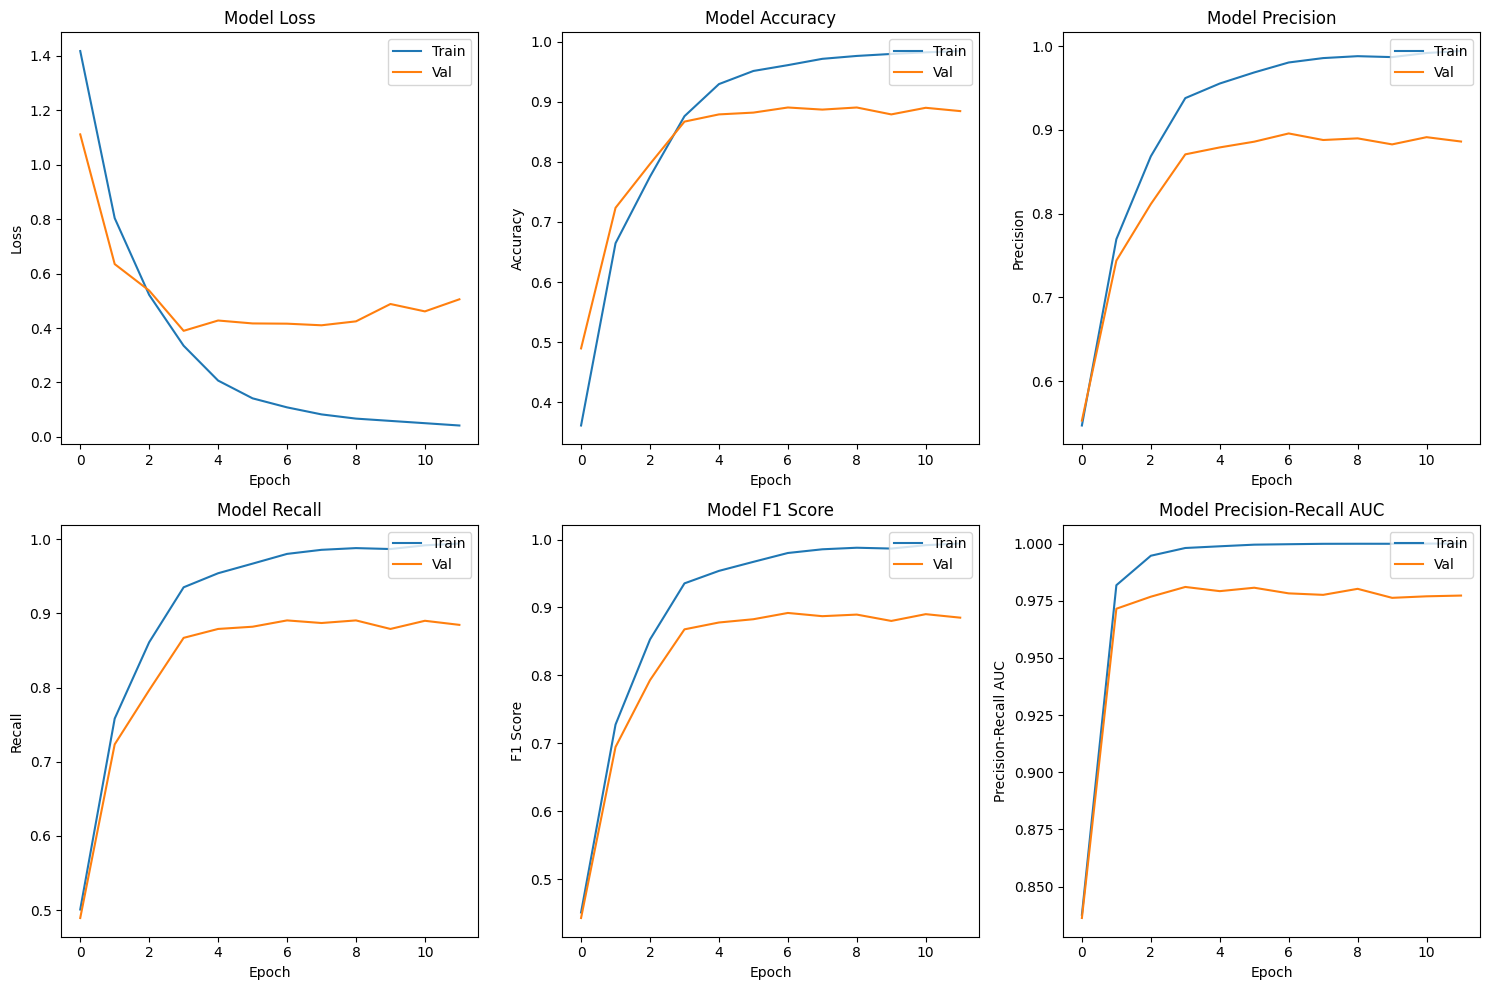

In [ ]:
import matplotlib.pyplot as plt
# Plotting the metrics
multi_plot_all_metrics(metrics_callback.metrics_data)

In [ ]:
from sklearn.metrics import classification_report
predictions = np.argmax(cnn_3gram.predict(val_data), -1)
print(classification_report(y_val, predictions, target_names=label_names))

63/63 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

     sadness       0.91      0.94      0.93       550
         joy       0.94      0.90      0.92       704
        love       0.69      0.85      0.77       178
       anger       0.91      0.87      0.89       275
        fear       0.91      0.83      0.87       212
    surprise       0.76      0.81      0.79        81

    accuracy                           0.89      2000
   macro avg       0.85      0.87      0.86      2000
weighted avg       0.90      0.89      0.89      2000



## Multi-filter CNN

* Convert the string input to a sequence of integers using vectorizer()
* Use an embedding layer to convert sequences into dense vectors of fixed size using a uniform distribution
* Apply dropout to the embedding layer to prevent overfitting.
* Loop over different filter sizes (2, 3, 4) to create convolutional layers with different n-grams.
* **Conv1D** layers are applied sequentially for each n-gram size, followed by global **max pooling** to reduce the output dimension.
* Concatenate the pooled outputs from each convolutional layer and add a dropout layer.
* Define the output layer with a softmax activation function for multi-class classification.
* Compile the model with categorical cross-entropy loss and Adam optimizer.

In [ ]:
#Create and train a CNN model with (2,3,4)-gram filters using Keras functional API
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

FILTERS = 128
DENSE = 512

# Model input, a string tensor
inputs = Input(shape=(1,), dtype=tf.string)
# Converts string input to a sequence of integers using a vectorizer
inputs_seq = vectorizer(inputs)

# Embeddings layer to convert sequences into dense vectors of fixed size
embeddings = Embedding(MAX_WORDS, EMBEDDING_DIM, embeddings_initializer="uniform",
                    input_length=MAX_SEQUENCE_LENGTH, trainable=True)(inputs_seq)

# Dropout over Embeddings
dropped_embeddings = Dropout(rate=0.2)(embeddings)

# Multi-filter CNNs
pooled_convs = []
filter_sizes = [2,3,4]

for n_gram in filter_sizes:
    # n-gram convolutions with padding
    convs = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1,
                    padding="valid", activation='relu',
                    name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)
    convs2 = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1,
                    padding="valid", activation='relu',
                    name='{}-gram_Convolutions_2'.format(n_gram))(convs)
    convs3 = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1,
                    padding="valid", activation='relu',
                    name='{}-gram_Convolutions_3'.format(n_gram))(convs2)


    # Max-Pooling over time
    pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs3))

# Concatenation of filters form all window sizes
concat =  concatenate(pooled_convs)
concat = Dropout(rate=0.5)(concat)
outputs = Dense(len(distinct_train_labels), activation='softmax')(concat)

multi_cnn = Model(inputs=inputs, outputs=outputs)
multi_cnn.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])

print(multi_cnn.summary())

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

early_stopping = EarlyStopping(
    patience=5, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True
)

# Create the metrics callback (assuming MetricsCallback is defined elsewhere in your code)
metrics_callback = Metrics((train_data, y_train_1_hot, val_data, y_val_1_hot), plot_results=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 30)                   0         ['input_2[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 300)              3000000   ['text_vectorization[1][0]']  
                                                          0                                       
                                                                                              

In [ ]:
history_multi_cnn = multi_cnn.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=128,
              epochs=20,
              shuffle=True,
              callbacks=[metrics_callback, early_stopping])

Epoch 1/20
125/125 [==============================] - 37s 286ms/step - loss: 1.2999 - categorical_accuracy: 0.4785 - val_loss: 0.7190 - val_categorical_accuracy: 0.7535
Epoch 2/20
125/125 [==============================] - 35s 284ms/step - loss: 0.4140 - categorical_accuracy: 0.8516 - val_loss: 0.2782 - val_categorical_accuracy: 0.9040
Epoch 3/20
125/125 [==============================] - 36s 288ms/step - loss: 0.2157 - categorical_accuracy: 0.9255 - val_loss: 0.2618 - val_categorical_accuracy: 0.9045
Epoch 4/20
125/125 [==============================] - 35s 279ms/step - loss: 0.1496 - categorical_accuracy: 0.9467 - val_loss: 0.2778 - val_categorical_accuracy: 0.8970
Epoch 5/20
125/125 [==============================] - 35s 278ms/step - loss: 0.1050 - categorical_accuracy: 0.9628 - val_loss: 0.3304 - val_categorical_accuracy: 0.8970
Epoch 6/20
125/125 [==============================] - 36s 288ms/step - loss: 0.0848 - categorical_accuracy: 0.9703 - val_loss: 0.3568 - val_categorical_acc

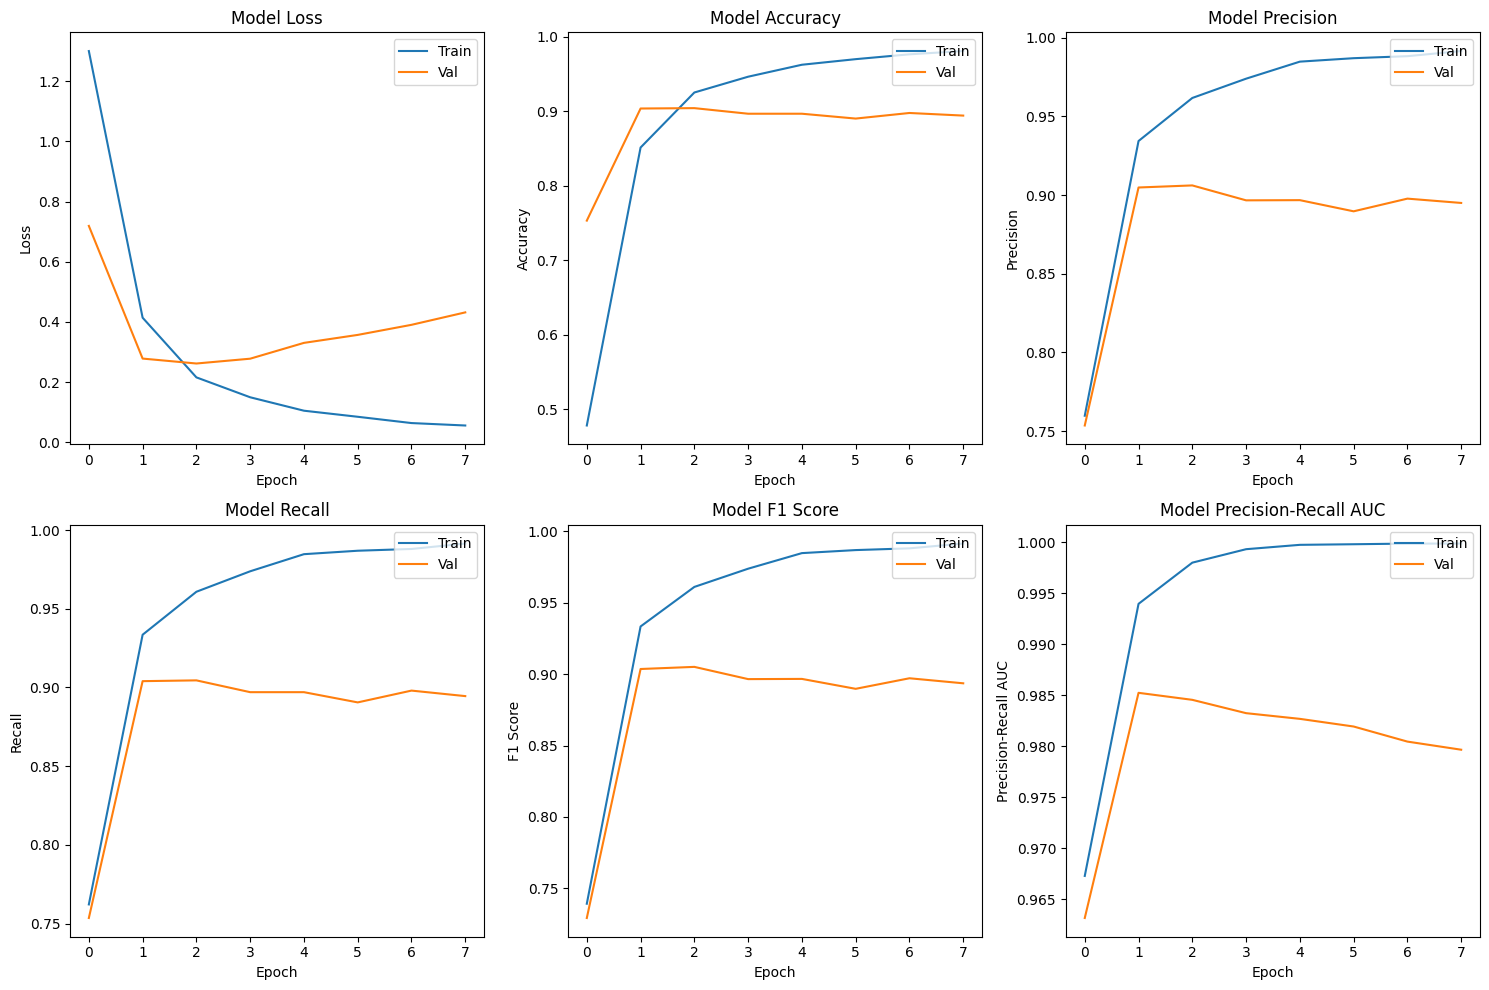

In [ ]:
# Plotting the metrics
multi_plot_all_metrics(metrics_callback.metrics_data)

In [ ]:
predictions = np.argmax(multi_cnn.predict(val_data), -1)
print(classification_report(y_val, predictions, target_names=label_names))

63/63 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

     sadness       0.94      0.94      0.94       550
         joy       0.94      0.91      0.93       704
        love       0.79      0.84      0.82       178
       anger       0.93      0.90      0.91       275
        fear       0.83      0.88      0.86       212
    surprise       0.79      0.80      0.80        81

    accuracy                           0.90      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.91      0.90      0.91      2000



# Hyperparameter tuning

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define a Model Building Function
class CNNHyperModel(HyperModel):
    def __init__(self, max_words, embedding_dim, max_sequence_length, num_classes):
        self.max_words = max_words
        self.embedding_dim = embedding_dim
        self.max_sequence_length = max_sequence_length
        self.num_classes = num_classes

    def build(self, hp):
        inputs = Input(shape=(1,), dtype=tf.string)
        inputs_seq = vectorizer(inputs)

        embeddings = Embedding(
            self.max_words,
            hp.Int('embedding_dim', min_value=50, max_value=300, step=50, default=self.embedding_dim),
            embeddings_initializer="uniform",
            input_length=self.max_sequence_length,
            trainable=True
        )(inputs_seq)

        dropped_embeddings = Dropout(rate=hp.Float('dropout_rate_embedding', 0.1, 0.5, step=0.1, default=0.2))(embeddings)

        pooled_convs = []
        filter_sizes = [2, 3, 4]

        for n_gram in filter_sizes:
            conv = dropped_embeddings
            for i in range(hp.Int('num_conv_layers', 1, 3, default=3)):
                conv = Conv1D(
                    filters=hp.Int('filters', min_value=64, max_value=256, step=64, default=128),
                    kernel_size=n_gram,
                    strides=1,
                    padding="valid",
                    activation='relu'
                )(conv)
            pooled_convs.append(GlobalMaxPooling1D()(conv))

        concat = concatenate(pooled_convs)
        concat = Dropout(rate=hp.Float('dropout_rate_concat', 0.3, 0.7, step=0.1, default=0.5))(concat)
        outputs = Dense(self.num_classes, activation='softmax')(concat)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=0.001)),
            metrics=["categorical_accuracy"]
        )
        return model


/tmp/ipykernel_91103/760695719.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [ ]:
# Initialize and Run the Tuner:
max_words = MAX_WORDS
embedding_dim = EMBEDDING_DIM
max_sequence_length = MAX_SEQUENCE_LENGTH
num_classes = len(distinct_train_labels)

hypermodel = CNNHyperModel(max_words, embedding_dim, max_sequence_length, num_classes)

tuner = RandomSearch(
    hypermodel,
    objective='val_categorical_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='cnn_text_classification'
)

tuner.search_space_summary()

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

early_stopping = EarlyStopping(
    patience=5, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True
)

tuner.search(train_data, y_train_1_hot,
             validation_data=(val_data, y_val_1_hot),
             batch_size=128,
             epochs=20,
             callbacks=[early_stopping])


Reloading Tuner from hyperparameter_tuning/cnn_text_classification/tuner0.json
Search space summary
Default search space size: 6
embedding_dim (Int)
{'default': 300, 'conditions': [], 'min_value': 50, 'max_value': 300, 'step': 50, 'sampling': 'linear'}
dropout_rate_embedding (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_conv_layers (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
filters (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout_rate_concat (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.3, 'max_value': 0.7, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# Retrieve the Best Model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 30)                   0         ['input_1[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 embedding (Embedding)       (None, 30, 300)              3000000   ['text_vectorization[2][0]']  
                                                          0                                       
                                                                                              

In [ ]:
# Train the best model and capture the history
best_model_history = best_model.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=128,
              epochs=20,
              shuffle=True,
              callbacks=[metrics_callback, early_stopping])

Epoch 1/20
125/125 [==============================] - 37s 294ms/step - loss: 0.1320 - categorical_accuracy: 0.9485 - val_loss: 0.2079 - val_categorical_accuracy: 0.9145
Epoch 2/20
125/125 [==============================] - 37s 296ms/step - loss: 0.1136 - categorical_accuracy: 0.9553 - val_loss: 0.2071 - val_categorical_accuracy: 0.9155
Epoch 3/20
125/125 [==============================] - 36s 289ms/step - loss: 0.0957 - categorical_accuracy: 0.9633 - val_loss: 0.2168 - val_categorical_accuracy: 0.9105
Epoch 4/20
125/125 [==============================] - 36s 288ms/step - loss: 0.0803 - categorical_accuracy: 0.9707 - val_loss: 0.2227 - val_categorical_accuracy: 0.9100
Epoch 5/20
125/125 [==============================] - 37s 298ms/step - loss: 0.0667 - categorical_accuracy: 0.9759 - val_loss: 0.2295 - val_categorical_accuracy: 0.9145
Epoch 6/20
125/125 [==============================] - 36s 291ms/step - loss: 0.0561 - categorical_accuracy: 0.9811 - val_loss: 0.2388 - val_categorical_acc

In [ ]:
# Evaluate the Best Model
predictions = np.argmax(best_model.predict(val_data), -1)
print(classification_report(y_val, predictions, target_names=label_names))


63/63 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

     sadness       0.95      0.94      0.95       550
         joy       0.94      0.94      0.94       704
        love       0.83      0.84      0.84       178
       anger       0.91      0.92      0.92       275
        fear       0.89      0.84      0.87       212
    surprise       0.79      0.85      0.82        81

    accuracy                           0.92      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.92      0.92      0.92      2000



# CNN with residual connection & maxpooling

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Add
from tensorflow.keras.models import Model

# Define input layer
input_layer = Input(shape=(1,), dtype=tf.string)

# Apply vectorizer
vectorized_text = vectorizer(input_layer)

# Define embedding layer
embedding_layer = Embedding(MAX_WORDS, EMBEDDING_DIM, embeddings_initializer="uniform",
                            input_length=MAX_SEQUENCE_LENGTH, trainable=True)(vectorized_text)

# Apply dropout
dropout_layer = Dropout(0.3)(embedding_layer)

# Path 1
conv1 = Conv1D(FILTERS, KERNEL, activation='relu', padding='same')(dropout_layer)
conv2 = Conv1D(FILTERS, KERNEL, activation='relu', padding='same')(conv1)
conv3 = Conv1D(FILTERS, KERNEL, activation='relu', padding='same')(conv2)

# Path 2
conv4 = Conv1D(FILTERS, KERNEL, activation='relu', padding='same')(dropout_layer)

# Residual connection
residual = Add()([conv1, conv4])

# Apply global max pooling
max_pooling = GlobalMaxPooling1D()(residual)

# Apply dropout
dropout_layer_2 = Dropout(0.3)(max_pooling)

# Apply dense layer
dense_layer = Dense(DENSE, activation='relu')(dropout_layer_2)

# Output layer
output_layer = Dense(len(distinct_train_labels), activation='softmax')(dense_layer)

# Create model
cnn_3gram = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
print(cnn_3gram.summary())

cnn_3gram.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

early_stopping = EarlyStopping(
    patience=10, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True
)

# Create the metrics callback (assuming MetricsCallback is defined elsewhere in your code)
metrics_callback = Metrics((train_data, y_train_1_hot, val_data, y_val_1_hot), plot_results=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 30)                   0         ['input_2[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 300)              3000000   ['text_vectorization[3][0]']  
                                                          0                                       
                                                                                            

In [ ]:
cnn_3gram_history = cnn_3gram.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=128,
              epochs=20,
              shuffle=True,
              callbacks=[metrics_callback, early_stopping])

Epoch 1/20
125/125 [==============================] - 29s 229ms/step - loss: 1.3383 - categorical_accuracy: 0.4753 - val_loss: 0.6792 - val_categorical_accuracy: 0.7555
Epoch 2/20
125/125 [==============================] - 27s 216ms/step - loss: 0.3771 - categorical_accuracy: 0.8732 - val_loss: 0.2679 - val_categorical_accuracy: 0.9015
Epoch 3/20
125/125 [==============================] - 26s 209ms/step - loss: 0.1914 - categorical_accuracy: 0.9324 - val_loss: 0.2417 - val_categorical_accuracy: 0.9140
Epoch 4/20
125/125 [==============================] - 26s 210ms/step - loss: 0.1252 - categorical_accuracy: 0.9546 - val_loss: 0.2679 - val_categorical_accuracy: 0.9060
Epoch 5/20
125/125 [==============================] - 26s 210ms/step - loss: 0.0881 - categorical_accuracy: 0.9697 - val_loss: 0.3038 - val_categorical_accuracy: 0.9070
Epoch 6/20
125/125 [==============================] - 26s 209ms/step - loss: 0.0648 - categorical_accuracy: 0.9759 - val_loss: 0.3399 - val_categorical_acc

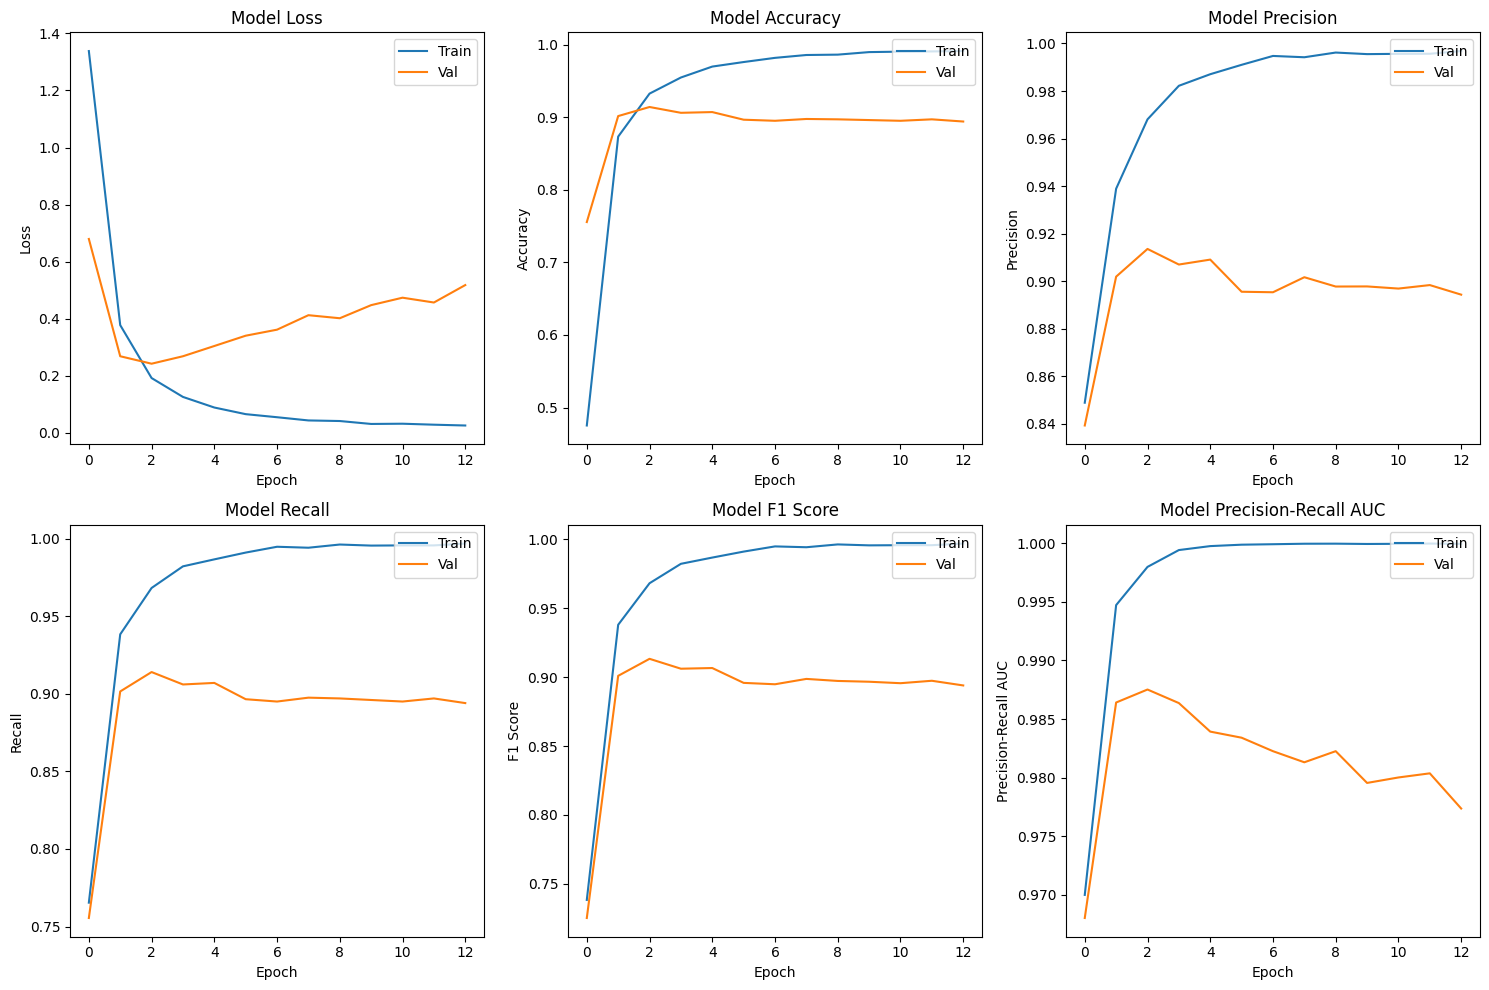

In [ ]:
# Plotting the metrics
multi_plot_all_metrics(metrics_callback.metrics_data)

In [ ]:
predictions = np.argmax(cnn_3gram.predict(val_data), -1)
print(classification_report(y_val, predictions, target_names=label_names))

63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     sadness       0.93      0.94      0.94       550
         joy       0.93      0.95      0.94       704
        love       0.87      0.84      0.86       178
       anger       0.89      0.95      0.92       275
        fear       0.91      0.81      0.86       212
    surprise       0.80      0.74      0.77        81

    accuracy                           0.91      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.91      0.91      0.91      2000



# Experiment with pre-trained word embeddings

In [ ]:
import numpy as np
import fasttext

fasttext_model = fasttext.load_model('cc.en.300.bin')
embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

for w2idx, _word in enumerate(vectorizer.get_vocabulary()):
    # Skip PAD and UNK tokens
    if w2idx < 2:
      continue
    embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

del fasttext_model

In [ ]:
# Create and train a CNN model with trigram filters
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, auc


FILTERS = 128
KERNEL = 3 # trigram
DENSE = 512
LAYERS = 5

# create empty sequential model
cnn_3gram = Sequential()
# Vectorizer layer
cnn_3gram.add(Input(shape=(1,), dtype=tf.string))
cnn_3gram.add(vectorizer)
# add an embedding layer
cnn_3gram.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=True))
# add 0.3 dropout probabillity
cnn_3gram.add(Dropout(0.3))
# add a stack of 5 convolution layers. In CNN layers we avoid to use dropout
for _ in range(LAYERS):
  cnn_3gram.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))

# max pooling => Here a fixed size representation is created
cnn_3gram.add(GlobalMaxPooling1D())
# add 0.3 dropout probability
cnn_3gram.add(Dropout(0.3))
# add dense layer
cnn_3gram.add(Dense(DENSE, activation='relu'))
# add final linear layer
cnn_3gram.add(Dense(len(distinct_train_labels), activation='softmax'))

print(cnn_3gram.summary())
cnn_3gram.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

early_stopping = EarlyStopping(
    patience=5, verbose=2, monitor="val_categorical_accuracy", mode="max", restore_best_weights=True
)

# Create the metrics callback (assuming MetricsCallback is defined elsewhere in your code)
metrics_callback = Metrics((train_data, y_train_1_hot, val_data, y_val_1_hot), plot_results=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 30, 300)           30000000  
                                                                 
 dropout_4 (Dropout)         (None, 30, 300)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 28, 128)           115328    
                                                                 
 conv1d_8 (Conv1D)           (None, 26, 128)           49280     
                                                                 
 conv1d_9 (Conv1D)           (None, 24, 128)           49280     
                                                        

In [ ]:
cnn_3gram_history = cnn_3gram.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=128,
              epochs=20,
              shuffle=True,
              callbacks=[metrics_callback, early_stopping])

Epoch 1/20
125/125 [==============================] - 29s 224ms/step - loss: 1.3960 - categorical_accuracy: 0.4057 - val_loss: 0.8588 - val_categorical_accuracy: 0.6735
Epoch 2/20
125/125 [==============================] - 28s 224ms/step - loss: 0.5891 - categorical_accuracy: 0.7812 - val_loss: 0.4064 - val_categorical_accuracy: 0.8485
Epoch 3/20
125/125 [==============================] - 28s 221ms/step - loss: 0.2939 - categorical_accuracy: 0.9017 - val_loss: 0.3066 - val_categorical_accuracy: 0.8960
Epoch 4/20
125/125 [==============================] - 28s 221ms/step - loss: 0.2133 - categorical_accuracy: 0.9261 - val_loss: 0.3058 - val_categorical_accuracy: 0.8955
Epoch 5/20
125/125 [==============================] - 28s 221ms/step - loss: 0.1709 - categorical_accuracy: 0.9423 - val_loss: 0.3155 - val_categorical_accuracy: 0.8990
Epoch 6/20
125/125 [==============================] - 28s 221ms/step - loss: 0.1244 - categorical_accuracy: 0.9579 - val_loss: 0.3303 - val_categorical_acc

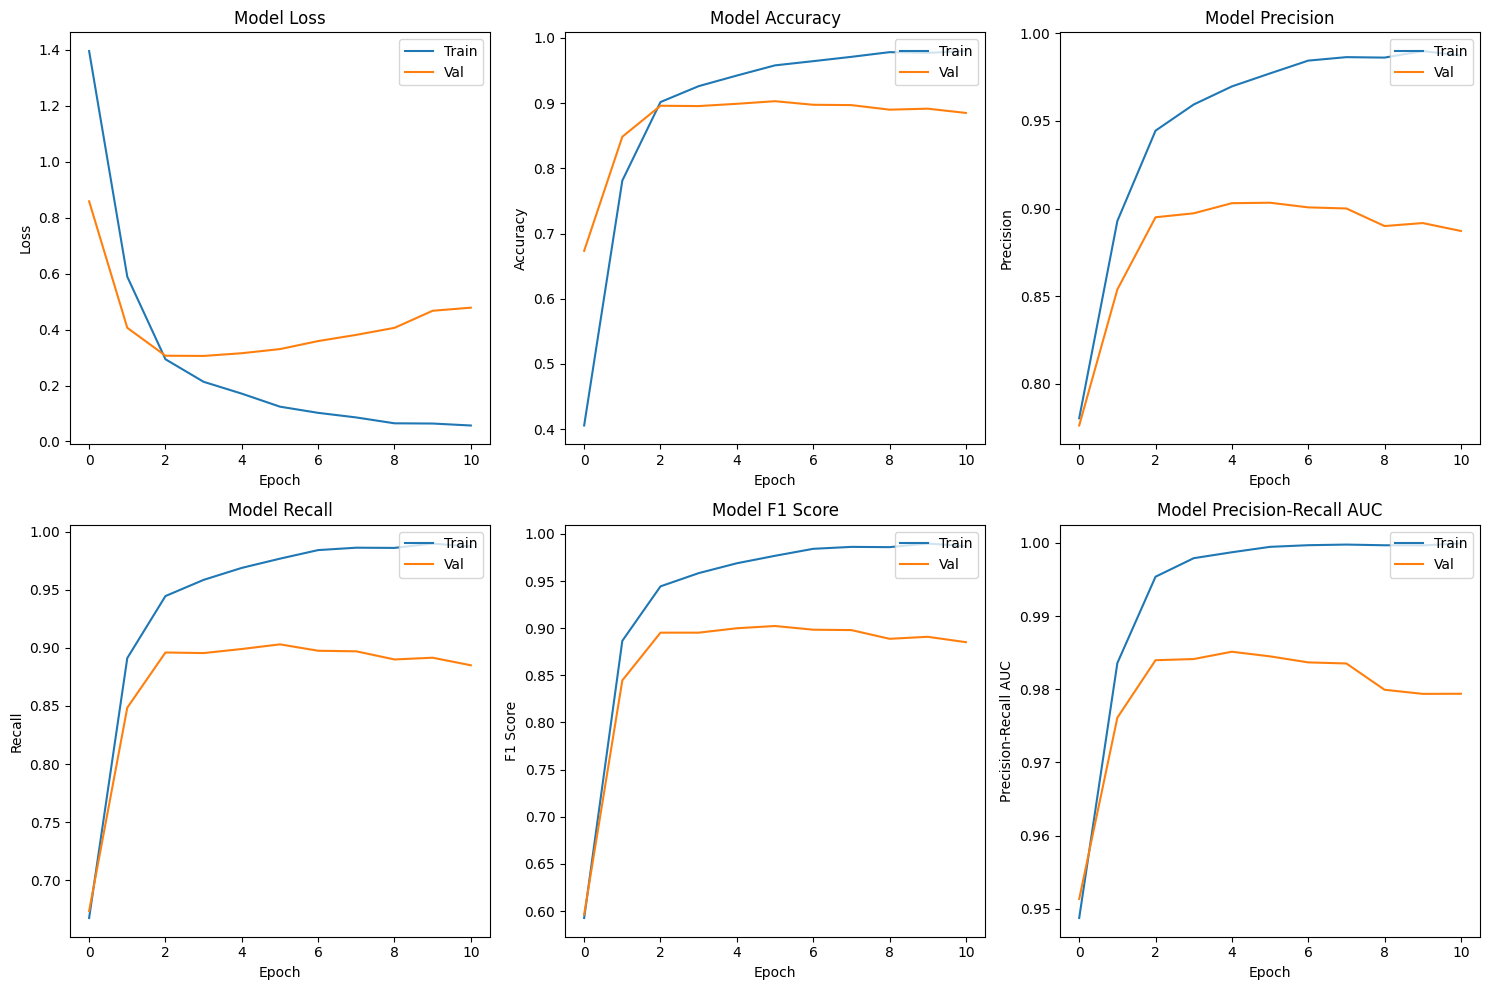

In [ ]:
# Plotting the metrics
multi_plot_all_metrics(metrics_callback.metrics_data)

In [ ]:
predictions = np.argmax(cnn_3gram.predict(val_data), -1)
print(classification_report(y_val, predictions, target_names=label_names))

63/63 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

     sadness       0.92      0.95      0.93       550
         joy       0.92      0.95      0.93       704
        love       0.87      0.80      0.84       178
       anger       0.90      0.89      0.89       275
        fear       0.90      0.78      0.83       212
    surprise       0.74      0.84      0.79        81

    accuracy                           0.90      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.90      0.90      0.90      2000



## Evaluate on test set

In [ ]:
test_data = np.array([[" ".join(x_test)] for x_test in X_test_tokenized])
predictions = np.argmax(cnn_3gram.predict(test_data), axis=-1)
print(classification_report(y_test, predictions, target_names=label_names))

63/63 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

     sadness       0.92      0.93      0.93       581
         joy       0.90      0.92      0.91       695
        love       0.76      0.72      0.74       159
       anger       0.89      0.85      0.87       275
        fear       0.90      0.81      0.85       224
    surprise       0.64      0.83      0.72        66

    accuracy                           0.88      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.88      0.88      0.88      2000

